# Modèles de régression avec scikit-learn : Qui sera le MVP ?

Les données analysées dans cet exercice proviennent d'un jeu de données concernant des joueurs de NBA et leurs performances pour la saison 2013-2014.

L'objectif est de réussir à prédire le nombre de points inscrits par joueur durant la saison, en fonction de différentes variables qui correspondent pour la plupart aux caractéristiques des matchs auquel le joueur a participé et ses performances sur le terrain.  

Le dataset contient 20 colonnes, parmi lesquelles :
- Champ :-- Description
- player :- Prénom et Nom du joueur
- age :---- L'âge du joueur au début de la saison
- g	:------ Nombre de matchs joués
- gs :----- Nombre de matchs débutés
- mp :----- Nombre de minutes joués par saison
- fg. :---- Pourcentage de field goals (paniers tirés autres que lancers francs) réussis
- tov :---- Nombre de récupération de ballon


Exécuter la cellule suivante pour importer les modules nécessaires :


In [2]:
import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

Exécuter les cellules suivantes pour :  
- Importer le fichier 'nba_2013.csv' dans un DataFrame appelé nba.
- Afficher les infos essentielles du DataFrame.

In [5]:
nba = pd.read_csv('nba.csv', sep=';')

display(nba.head())

display(nba.info())

,player,pos,age,bref_team_id,g,gs,mp,fg.,efg.,ft.,orb,drb,trb,ast,stl,blk,tov,pf,pts,season
0,Lavoy Allen,PF,24,TOT,65,2,1072,0.447,0.450,0.660,119,192,311,71,24,33,44,126,303,2013-2014
1,Chris Andersen,C,35,MIA,72,0,1396,0.644,0.649,0.710,129,250,379,19,32,97,53,162,477,2013-2014
2,Pero Antic,PF,31,ATL,50,26,925,0.418,0.514,0.758,57,152,209,58,19,12,55,126,352,2013-2014
3,Darrell Arthur,SF,25,DEN,68,1,1161,0.395,0.424,0.855,52,158,210,61,39,47,58,185,401,2013-2014
4,Jeff Ayres,PF,26,SAS,73,10,952,0.580,0.580,0.691,89,169,258,60,13,25,63,146,240,2013-2014


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   player        117 non-null    object 
 1   pos           117 non-null    object 
 2   age           117 non-null    int64  
 3   bref_team_id  117 non-null    object 
 4   g             117 non-null    int64  
 5   gs            117 non-null    int64  
 6   mp            117 non-null    int64  
 7   fg.           117 non-null    float64
 8   efg.          117 non-null    float64
 9   ft.           113 non-null    float64
 10  orb           117 non-null    int64  
 11  drb           117 non-null    int64  
 12  trb           117 non-null    int64  
 13  ast           117 non-null    int64  
 14  stl           117 non-null    int64  
 15  blk           117 non-null    int64  
 16  tov           117 non-null    int64  
 17  pf            117 non-null    int64  
 18  pts           117 non-null    

None

La cellule suivante permet de nettoyer les données

In [6]:
# On rédifinit l'index de notre dataframe nba avec le joueur et l'id de l'équipe
nba.index = nba['player'] + ' - ' + nba['bref_team_id']

# On supprime les données manquantes
nba = nba.dropna()

# On affiche le nombre d'occurences de chaque poste
display(nba['pos'].value_counts())

# On assigne la variable pos à pl_pos
pl_pos = nba['pos']

# On supprime les colonnes season, player, bref_team_id et pos
nba = nba.drop(['season', 'player', 'bref_team_id', 'pos'], axis=1)

# On ajoute au dataframe les dummies 
nba = nba.join(pd.get_dummies(pl_pos, prefix='pos'))

# Nous pouvons supprimer une des colonnes relatives au poste car elle n'apporte aucune information supplémentaire. En effet,
# Si un joueur n'est à aucun des postes présents dans le tableau, on peut en déduire qu'il détient le dernier poste que nous
# avons retiré.

nba = nba.drop('pos_SG', axis=1)

SF    28
SG    25
PF    20
C     20
PG    20
Name: pos, dtype: int64

Les données sont ensuite séparées entre variables explicatives et variable cible.

In [7]:
data = nba.drop('pts', axis=1)
target = nba['pts']

Une partie des données est mise de côté pour le test du modèle, après apprentissage.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

Nous pouvons à présent standardiser les données en utilisant le fit sur le set de train.

In [9]:
scaler = preprocessing.StandardScaler()

X_train[X_train.columns] = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)

X_test[X_test.columns] = pd.DataFrame(scaler.transform(X_test), index=X_test.index)

Une heatmap de corrélations entre toutes les variables du DataFrame permet de repérer les variables importantes et celles colinéaires entre elles.

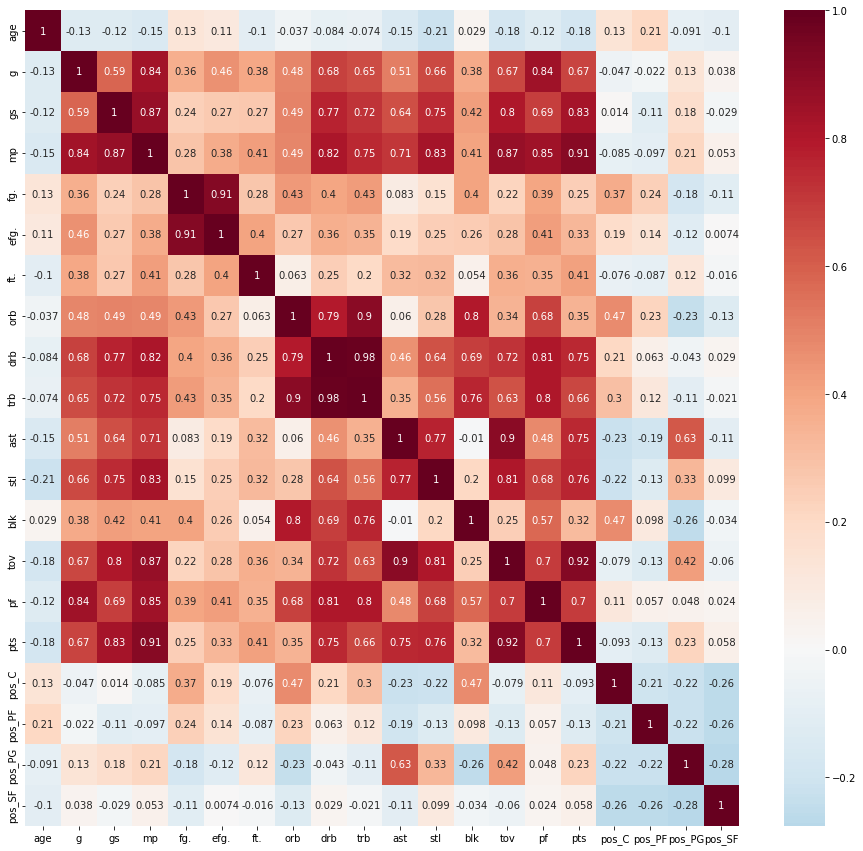

In [10]:
plt.figure(figsize=(16, 15))

sns.heatmap(nba.corr(), annot=True, cmap='RdBu_r', center=0);

La variable **mp** comptant le nombre de minutes jouées sur la saison est visiblement la plus corrélée à la variable cible.
Elle va donc être utilisée pour créer un modèle de régression linéaire simple pour prédire le nombre de points qu'un joueur marquera durant la saison.

In [12]:
model_1 = LinearRegression()
model_1.fit(X_train[['mp']], y_train)

LinearRegression()

Les coefficients de détermination et les racines des erreurs quadratiques moyennes sont deux métriques permettant d'évaluer les performances du modèle sur l'échantillon d'apprentissage et celui de test.

In [13]:
print('score train :',model_1.score(X_train[['mp']], y_train))
print('score test :', model_1.score(X_test[['mp']], y_test))


pred = model_1.predict(X_train[['mp']])
pred_test = model_1.predict(X_test[['mp']])
print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test : ', np.sqrt(mean_squared_error(y_test, pred_test)))

score train : 0.8415404344806197
score test : 0.7781677387147737
rmse train : 188.7661910723509
rmse test :  296.3264334597754


Nous possédons une vingtaine de variables différentes, ainsi il est dommage de se contenter de l'information contenue dans une seule d'entre elles pour construire notre modèle prédictif.

Il convient donc de tester un modèle de régression multiple afin d'utiliser le maximum d'informations disponibles dans notre base de données.

Un modèle de régression Elastic Net, permet d'éviter le sur-apprentissage et de s'affranchir des variables peu significatives. Il est créé et entraîné par validation croisée afin de choisir les meilleurs paramètres au regard de la performance

In [ ]:
model_en = ElasticNetCV(cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))

model_en.fit(X_train, y_train)
# pb ici ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. X xxx )

Un graphique est l'un des outils les plus efficaces pour mesurer l'influence d'un paramètre sur le modèle.

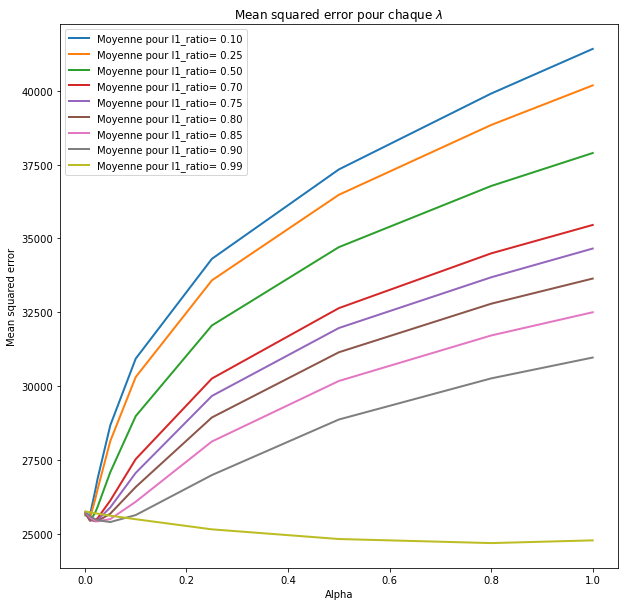

In [15]:
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

Les différents scores de performances sont ensuite affichés pour les deux échantillons.

In [16]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)

print("rmse train :", np.sqrt(mean_squared_error(y_train, pred_train)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))
print("score train :",model_en.score(X_train, y_train))
print("score test :", model_en.score(X_test, y_test))

rmse train : 119.61816926268516
rmse test : 164.97669832790976
score train : 0.9363696462007594
score test : 0.9312410661507059


La faible différence de score entre l'échantillon d'entraînement et l'échantillon de test signifie que le modèle n'est pas (ou peu) altéré par un effet de sur-apprentissage.

Comme prévu, en comparant avec les résultats du modèle simple, le modèle créé avec plus de variables s'ajuste mieux aux données et produit des prévisions plus précises.

Les points prédits par le modèle sont finalement comparés aux points observés pour mesurer l'efficacité réelle du modèle

In [17]:
moy = scaler.mean_[-1]
ec = scaler.scale_[-1]
print("moyenne :", moy)
print("ecart-type :", ec)

pd.DataFrame({'points_observés': (y_test*ec)+moy, 'points_predits': np.round((pred_test*ec)+moy)}, 
             index=X_test.index).head(7)

moyenne : 0.25
ecart-type : 0.4330127018922193


,points_observés,points_predits
Khris Middleton - MIL,428.932575,430.0
Jae Crowder - DAL,154.402522,159.0
Lavoy Allen - TOT,131.452849,100.0
Wilson Chandler - DEN,366.578746,301.0
Al Harrington - WAS,97.677858,98.0
Eric Gordon - NOP,428.066549,484.0
Brandon Rush - UTA,34.458003,74.0


Les prévisions sont correctes, compte tenu de la variabilité de la variable à prédire, et de la difficulté à prédire ce genre de variables.

# Régression linéaire simple

L'objectif de cet exercice est de se familiariser avec la notion de régression linéaire.

Pour rappel, étant données deux variables X et Y, dites respectivement variable explicative et variable expliquée, la régression linéaire simple consiste en la modélisation d'un lien entre la variable explicative et la variable expliquée.
On prédit la valeur de Y à partir des mesures des valeurs de X.

Le modèle usuel de régression linéaire simple est le suivant :  y = β0 + β1.x + ε 
où :

- y  est une variable quantitative continue à expliquer (ou variable dépendante).
- x  est une variable quantitative continue explicative.
- ε  est un terme d’erreur aléatoire de loi normale d’espérance nulle et d’écart-type σ.

Le modèle de régression estimera les coefficients  β0  et  β1  par  β̃ 0  et  β̃ 1.x ,   
nous permettant de calculer les valeurs ajustées  ỹ = β̃ 0 + β̃ 1.x  

Les résidus sont définis par  ε = y−ỹ  
Au cours des exercices suivants, l'objectif sera de prédire le prix de vente d'une voiture en fonction de ses caractéristiques.  

Le jeu de données utilisé dans la suite contient de nombreuses caractéristiques à propos de différentes voitures observées en 1985.  
Par soucis de simplicité, seules les variables numériques ont été gardées et les lignes comprenant des valeurs manquantes ont été supprimées.  

- L'attribut 'symboling' correspond au degré de risques de la voiture que l'assurance estime.
- L'attribut 'normalized_losses' est le coût moyen relatif par an d'assurance du véhicule. Cette valeur est normalisée pour les voitures appartenant à la même classe de types de véhicule.
- Les 13 attributs suivants concernent les caractéristiques techniques des différentes voitures comme la largeur, la cylindrée du moteur, le cheval-vapeur etc...

Le dernier attribut correspond au prix de vente du véhicule.  
- (a) Importer les modules pandas en tant que pd et numpy en tant que np.
- (b) Importer matplotlib.pyplot en tant que plt.
- (c) Importer les fonctions cross_validate et cross_val_predict de sklearn.model_selection ainsi que la classe LinearRegression de sklearn.linear_model.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.linear_model import LinearRegression

In [3]:
# (d) Lire le fichier 'automobiles.csv' dans un DataFrame appelé df
df = pd.read_csv('automobiles.csv', sep=';')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          120 non-null    int64  
 1   normalized-losses  120 non-null    int64  
 2   wheel-base         120 non-null    float64
 3   length             120 non-null    float64
 4   width              120 non-null    float64
 5   height             120 non-null    float64
 6   curb-weight        120 non-null    int64  
 7   engine-size        120 non-null    int64  
 8   bore               120 non-null    float64
 9   stroke             120 non-null    float64
 10  compression-ratio  120 non-null    float64
 11  horsepower         120 non-null    int64  
 12  peak-rpm           120 non-null    int64  
 13  city-mpg           120 non-null    int64  
 14  highway-mpg        120 non-null    int64  
 15  price              120 non-null    int64  
dtypes: float64(7), int64(9)
me

In [4]:
df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,13950
1,2,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,17450
2,1,158,105.8,192.7,71.4,55.7,2844,136,3.19,3.4,8.5,110,5500,19,25,17710
3,1,158,105.8,192.7,71.4,55.9,3086,131,3.13,3.4,8.3,140,5500,17,20,23875
4,2,192,101.2,176.8,64.8,54.3,2395,108,3.50,2.8,8.8,101,5800,23,29,16430


In [5]:
# (f) Afficher les statistiques descriptives élémentaires des colonnes de df
df.describe()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
count,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000
mean,0.616667,116.166667,98.265000,171.750000,65.560000,53.792500,2432.108333,117.766667,3.287667,3.254917,10.145083,93.650000,5106.250000,26.891667,32.308333,11325.575000
std,1.203520,34.808319,5.137057,11.684616,1.963978,2.186135,472.966870,30.496103,0.263310,0.281819,3.928973,28.210389,494.956178,5.919340,6.473989,6185.521276
min,-2.000000,65.000000,86.600000,141.100000,60.300000,49.400000,1488.000000,61.000000,2.910000,2.640000,7.000000,48.000000,4200.000000,15.000000,18.000000,5151.000000
25%,0.000000,91.000000,95.400000,166.300000,64.000000,52.000000,2118.750000,97.000000,3.050000,3.095000,8.700000,70.000000,4800.000000,23.000000,28.750000,7370.000000
50%,1.000000,104.000000,96.900000,172.200000,65.400000,54.100000,2332.500000,109.000000,3.190000,3.350000,9.000000,86.000000,5000.000000,26.000000,32.000000,9021.500000
75%,1.250000,134.750000,101.200000,176.800000,66.500000,55.500000,2672.250000,132.250000,3.580000,3.410000,9.400000,114.000000,5500.000000,30.250000,37.000000,12949.750000
max,3.000000,256.000000,115.600000,202.600000,71.700000,59.800000,4066.000000,258.000000,3.780000,4.170000,23.000000,176.000000,6600.000000,49.000000,54.000000,35056.000000


Le DataFrame contient 13 colonnes, mais dans cette première partie nous nous intéresserons uniquement à l'attribut 'curb-weight' et à la variable 'price'.

La régression linéaire, dans sa forme générale, suppose que la relation entre la variable cible et la(les) variable(s) explicative(s) est linéaire.
Il faut donc vérifier que cette hypothèse ait du sens.

- (g) Afficher un nuage de points entre les colonnes 'curb-weight' et 'price' de df.

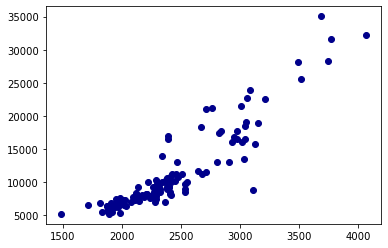

In [6]:
# Insérez votre code ici plt.figure(figsize=(10, 8))

plt.scatter(df['curb-weight'], df['price'], color='darkblue');

Les points semblent s'aligner le long d'une courbe proche d'une droite, le lien linéaire entre ces deux variables est donc plausible.

Il est à présent possible de construire un modèle de régression linéaire grâce à la classe LinearRegression du sous module sklearn.linear_model.
La construction du modèle est basée sur la Méthode des moindres carrés ordinaire (MCO) qui consiste à minimiser la somme des carrés des écarts entre chaque point du nuage de régression et son projeté sur la droite de régression.

- (h) Créer les vecteurs prix et mv contenant respectivement la variable cible price et les valeurs prises par la variable curb-weight. On fera attention à ce que prix soit de type Series et mv de type DataFrame pour pouvoir utiliser les modèles plus tard.

In [7]:
prix = df['price']
mv = df[['curb-weight']]

- (i) Instancier un régresseur slr grâce à la classe LinearRegression.
- (j) Ajuster le modèle aux données mv et prix.

Le modèle slr créé possède les attributs intercept_ et coef_ qui correspondent à l'ordonnée à l'origine et la pente de la droite dans le cas d'une régression linéaire simple.

- (k) Afficher l'intercept et l'unique coefficient estimé pour créer le modèle.

In [9]:
slr = LinearRegression()
slr.fit(mv, prix)

LinearRegression()

Le modèle slr créé possède les attributs intercept_ et coef_ qui correspondent à l'ordonnée à l'origine et la pente de la droite dans le cas d'une régression linéaire simple.

- (k) Afficher l'intercept et l'unique coefficient estimé pour créer le modèle.

In [10]:
print(slr.intercept_)
print(slr.coef_)

-17610.52577483149
[11.89753778]


Ici le modèle peut se modélise de cette façon :  prix=−15378.2+10.9∗curb−weightprix=−15378.2+10.9∗curb−weight .
En d'autres termes, si le poids à vide d'un véhicule augmente d'une unité de masse, son prix augmente de 10,9 euros.

Attention cependant aux mauvaises interprétations : le coefficient de régression permet d'analyser la relation entre deux variables et non l'intensité ou la causalité de cette relation.

Par défaut sur scikit-learn, le score calculé pour l'évaluation des performances d'une régression est le coefficient de détermination (R²). Dans le cas d'une régression linéaire simple, ce coefficient équivaut au rapport entre la variance expliquée et la variance totale.
Le meilleur score possible vaut 1 et le score peut être négatif. Plus le score se rapproche de 1, plus le modèle est performant.

- (l) Evaluer le modèle slr par validation croisée à 4 échantillons.
- (m) Afficher les scores obtenus sur les échantillons d'entraînement et de test, grâce à la fonction cross_validate, avec les paramètres return_train_score=True, cv=4.

In [11]:
cross_validate(slr, mv, prix, return_train_score=True, cv=4)

{'fit_time': array([0.00499964, 0.00199842, 0.00401545, 0.00399947]),
 'score_time': array([0.00299978, 0.00300121, 0.00198483, 0.00400019]),
 'test_score': array([ 0.57235676,  0.86635987, -2.96814006,  0.73350285]),
 'train_score': array([0.87011404, 0.72300967, 0.86193002, 0.82772507])}

- (n) Afficher la moyenne des scores obtenus sur les échantillons de test.

In [12]:
cross_validate(slr, mv, prix, return_train_score=True, cv=4)['test_score'].mean()

-0.19898014624219512

Cette valeur signifie que la masse à vide en ordre de marche d'une voiture explique environ 75% de la variance du prix.

Le coefficient R² se base sur les résidus : les différences entre la valeur ajustée de chaque point et sa valeur réelle.

Une fois les paramètres du modèle ajustés, on peut les utiliser afin de 'prédire' la variable cible pour de nouvelles valeurs de(des) variable(s) explicative(s), grâce à la méthode predict appliquée au modèle.
On peut également l'utiliser pour calculer les valeurs ajustées par le modèle.

- (o) Calculer les valeurs ajustées dans un tableau appelé pred_prix, puis calculer les résidus dans residus.

In [13]:
pred_prix = slr.predict(mv)
residus = pred_prix - prix
residus.describe()

count    1.200000e+02
mean     2.940700e-12
std      2.568259e+03
min     -8.824099e+03
25%     -1.181595e+03
50%      2.139708e+02
75%      1.409187e+03
max      1.061282e+04
Name: price, dtype: float64

Pour avoir une idée de comment le modèle linéaire s'adapte aux données, le plus efficace reste de tracer la droite de régression sur le nuage de points affiché plus haut.

- (p) Afficher un nuage de point entre les valeurs de 'curb-weigtht' et les prix.
- (q) Afficher sur le même graphique la droite de régression grâce aux prédictions pred_prix.

In [ ]:
plt.figure(figsize=(10, 8))

plt.scatter(mv['curb-weight'], prix, color='darkblue')
plt.plot(mv, pred_prix ,color='r')
# PB ici error InvalidIndexError: (slice(None, None, None), None)

In [17]:
""" manque la droute de regression qui cause probleme """

' manque la droute de regression qui cause probleme '

La droite de régression semble raisonnablement ajustée, quelques points sont plus éloignés de la droite, notamment ceux avec un prix élevé, mais l'ensemble reste relativement correct.

Les valeurs aberrantes peuvent avoir une grande influence sur les modèles de régression linéaire : puisque le propre de la régression est la minimisation des résidus au carré, les résidus importants ont une influence disproportionnée sur le modèle.

L'affichage de la droite nous aide à détecter les valeurs aberrantes influentes. Dans notre graphique, il ne semble pas y avoir de valeurs aberrantes influentes.

A titre d'exemple, pour illustrer l'influence que peut avoir une valeur aberrante, prenons le cas extrême dans lequel nous ajoutons à notre DataFrame une seule donnée aberrante, une voiture très légère et très chère.
Nous calculons un nouveau modèle de régression, et nous obtenons la droite suivante, beaucoup moins bien ajustée aux données :

Pour savoir si une variable est significative, c'est-à-dire si elle influence vraiment la variable, on peut avoir recours à un test d'hypothèse :

- On pose l'hypothèse H0 suivante:  β1 = 0 .
- On calcule la statistique du test de Fisher correspondant à cette hypothèse, puis la p-valeur qui représente la probabilité de rejeter l'hypothèse nulle alors qu'elle est vraie.
- Plus elle est petite (en général au moins < 0.05) plus on peut rejeter l'hypothèse H0 et plus la variable explicative associée est significative.  

La fonction f_regression de sklearn.feature_selection renvoie les statistiques de tests, ainsi que la p-valeur associée pour chaque couple (variable(s) explicative(s), variable à expliquer).

- (r) Importer la fonction f_regression, afficher la F-statistique et la p-value associée au test H0:  β1 = 0 .

In [18]:
from sklearn.feature_selection import f_regression

print('F-statistique :', f_regression(mv, prix)[0], 'p-value :', f_regression(mv, prix)[1])
## p-value ~ 0 donc la variable mv très significative.

F-statistique : [566.47393437] p-value : [7.2509887e-47]


Une autre métrique souvent utilisée pour évaluer un modèle de régression est la racine de l'erreur quadratique (RMSE en anglais).

RMSE
 
Contrairement au R², qui ne s'applique qu'aux modèles de régression linéaire, le RMSE est une métrique d'évaluation universelle qui nous permet de comparer les performances de prédiction de différents types de modèles.

Le RMSE est la racine carrée de la moyenne des résidus au carré.

- (s) Écrire une fonction qui retourne le RMSE d'un couple de prédictions et de valeurs réelles reçus en arguments.
- (t) Appliquer la fonction à pred_prix et prix.

In [19]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets)**2).mean())

rmse(pred_prix, prix)

2557.5357270899494

De toute évidence, plus l'erreur quadratique moyenne est proche de 0, plus précises sont les prédictions.  

En revanche, le RMSE ne s'interprète pas si facilement lorsqu'il est calculé sur un seul modèle, et sert souvent plus de comparateur entre plusieurs modèles.
Il est en effet complètement dépendant de l'échelle de la variable cible, ou variable à expliquer. Il n'y a donc pas de seuil permettant de juger de la bonne performance d'un modèle.
En outre, ici il est élevé puisqu'il est calculé sur une variable cible contenant des prix de voitures de moyenne de 11445. D'autre part, les données sont NON normalisées.

La fonction **cross_val_predict** de sklearn.model_selection permet d'effectuer des prédictions sur un ensemble de données par validation croisée, et retourne pour chacun des éléments du jeu de données, la prédiction obtenue pour cet élément lorsqu'il était dans l'échantillon de test.   

En pratique, les données sont divisées en un nombre **k** d'échantillons, puis **k** régressions sont réalisées en mettant de côté à chaque étape un échantillon différent parmi les **k**.
Les prédictions sont ensuite calculées pour chaque élément de cet échantillon mis de côté, à partir des coefficients calculés sur les autres.

- (u) Retourner les prédictions obtenues par **cross_val_predict**, avec un nombre d'échantillons cv=4 dans un tableau **pred_prix2**.
- (v) Calculer le RMSE associé à ces prédictions.

# 3 -La Régression linéaire multiple

Contexte et objectif

L'objectif de cet exercice est de se familiariser avec la notion de régression linéaire multiple.
On rappelle que le modèle usuel de régression linéaire multiple est le suivant :

yi=β0+β1.xi,1 + β2.xi,2 + ⋯ + βp.xi,p + εi = β0 + ∑ βj.xi,j + εi
 
où :

- yi est une variable quantitative continue à expliquer (ou variable dépendante).
- x1,…,xp sont des variables quantitatives continues explicatives.
- les εi sont des termes d'erreur aléatoire de loi normale d'espérance nulle et d'écart-type σ.

Nous utiliserons dans cet exercice les mêmes données que dans l'exercice précédent pour construire un modèle de prévision du prix de certaines voitures à partir de caractéristiques techniques de celles-ci.  

À présent, cette prédiction se fera en utilisant plusieurs variables explicatives, et en sélectionnant celles qui paraissent les plus pertinentes.

In [2]:
import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
%matplotlib inline 

import scipy.stats as stats
import seaborn as sns

In [3]:
df = pd.read_csv('automobiles.csv', sep=';')
df.head()

,symboling,normalized-losses,wheel-base,length,width,height,curb-weight,engine-size,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,2,164,99.8,176.6,66.2,54.3,2337,109,3.19,3.4,10.0,102,5500,24,30,13950
1,2,164,99.4,176.6,66.4,54.3,2824,136,3.19,3.4,8.0,115,5500,18,22,17450
2,1,158,105.8,192.7,71.4,55.7,2844,136,3.19,3.4,8.5,110,5500,19,25,17710
3,1,158,105.8,192.7,71.4,55.9,3086,131,3.13,3.4,8.3,140,5500,17,20,23875
4,2,192,101.2,176.8,64.8,54.3,2395,108,3.50,2.8,8.8,101,5800,23,29,16430


Lorsque l'on est confronté à une tâche de modélisation prédictive, il y a souvent plus d'une variable dans le jeu de données qui peuvent aider à expliquer le comportement de la variable cible.  

Il est donc recommandé d'inclure davantage de variables explicatives dans un modèle de régression linéaire en incluant simplement plus de colonnes dans le DataFrame transmis à la fonction d'apprentissage du modèle.

- (c) Extraire du DataFrame df le prix des voitures dans une variable target, et le reste des colonnes dans data.
- (d) Séparer les données en un ensemble d'apprentissage (X_train,y_train) et un ensemble de test (X_test, y_test) contenant 20% du total des données.  
NB : Ajouter random_state=789 pour la reproductibilité des résultats

In [4]:
data = df.drop('price', axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)

## Premier modèle
- (a) Instancier un régresseur lr de la classe LinearRegression.
- (b) Ajuster le modèle à l'ensemble d'entraînement X_train et y_train.

In [5]:
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

- (c) Afficher l'intercept ainsi que les coefficients de chaque variable estimée par le modèle.

In [6]:
coeffs = list(lr.coef_)
coeffs.insert(0, lr.intercept_)

feats = list(data.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,-61064.347779
symboling,-279.411200
normalized-losses,25.099243
wheel-base,265.026304
length,-208.494696
width,823.118628
height,223.137737
curb-weight,7.178564
engine-size,75.760882
bore,-2782.431914


- (d) Afficher le score (R²) du modèle sur l'échantillon d'apprentissage.
- (e) Afficher le score obtenu par validation croisée grâce à la fonction cross_val_score().

In [7]:
print('Coefficient de détermination du modèle :', lr.score(X_train, y_train))
print('Coefficient de détermination obtenu par Cv :', cross_val_score(lr,X_train,y_train).mean())

Coefficient de détermination du modèle : 0.901694676292453
Coefficient de détermination obtenu par Cv : 0.622980756421853


Les scores obtenus sur l'échantillon d'apprentissage sont corrects.
Le modèle est bien ajusté aux données, mais potentiellement trop ajusté.
La baisse du coefficient R² lors de l'évaluation par validation croisée laisse effectivement supposer un problème de sur-apprentissage.

- (f) Afficher le score du modèle sur l'ensemble de test.

In [8]:
lr.score(X_test, y_test)

0.901313338754559

- (g) Stocker les prédictions du modèle pour X_test dans pred_test et afficher dans un graphique le nuage de points entre pred_test et y_test, en ajoutant la droite d'équation  y=xy=x .

Si les prédictions sont bonnes, les points devraient être proches de cette droite.

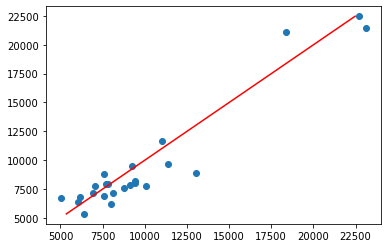

In [17]:
pred_test = lr.predict(X_test)
plt.scatter(pred_test, y_test)
plt.plot((y_test.min(), y_test.max()), (y_test.min(), y_test.max()), c='r'); # on affiche y=x avec A= (5348, 5348) et B=(22470, 22470) <=> plot(x, y)


In [11]:
(y_test.min(), y_test.max())

(5348, 22470)

La régression linéaire est fondée entre autres sur deux hypothèses sur les erreurs : l'homoscédasticité et la normalité.
Nous ne disposons pas des erreurs mais des résidus, qui sont les erreurs observées.
En outre l'étude des résidus permet de s'assurer une conformité avec ces hypothèses.

Un premier graphique simple représentant les résidus en fonction de la variable cible permet de se faire un avis sur l'homoscédasticité des résidus, qui devraient être disséminés dans le graphique au hasard autour de la droite  y=0y=0 , sans structure apparente.

- (h) Calculer les valeurs ajustées (pred_train) puis les résidus (residus) du modèle.
- (i) Afficher le nuage des points représentant les résidus en fonction des valeurs de y_train.

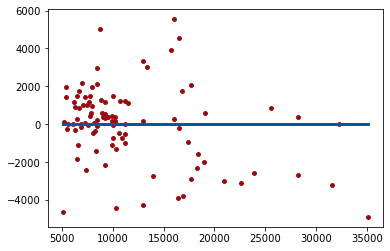

In [18]:
pred_train = lr.predict(X_train)
residus = pred_train - y_train

plt.scatter(y_train, residus, color='#980a10', s=15)
plt.plot((y_train.min(), y_train.max()), (0, 0), lw=3, color='#0a5798')

Les points sont répartis uniformément autour de la droite d'équation  y=0y=0  car la moyenne des résidus avoisine 0.
Cependant on constate une structure dans leur répartition. En effet, plus le prix est bas plus les points sont proches de la droite. Plus le prix augmente, plus les résidus s'éloignent du centre et deviennent négatifs.

La fonction probplot de scipy.stats permet d'afficher un diagramme Quantile-Quantile ou (Q-Q plot) qui permet d'évaluer la pertinence de l'ajustement d'une distribution donnée à un modèle théorique (souvent une loi gaussienne centrée réduite).
Ainsi la normalité des résidus (une fois centrés réduis) se valide facilement; si les points sont alignés sur la première bissectrice, c'est que la distribution des résidus suit probablement une loi gaussienne normalisée.

- (j) Centrer réduire les résidus dans un vecteur appelé residus_norm.
- (k) Afficher le QQ-Plot en appliquant la fonction stats.probplot à residus_norm.
- (l) Ajouter l'argument plot=plt pour pouvoir l'afficher avec matplotlib grâce à la commande plt.show().

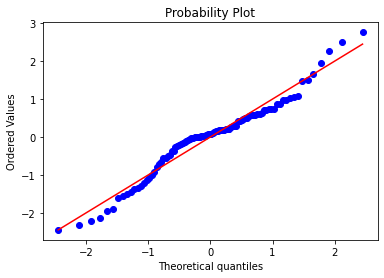

In [19]:
residus_norm = (residus-residus.mean())/residus.std()

stats.probplot(residus_norm, plot=plt)

plt.show();

L'hypothèse de normalité est plausible, les points s'alignant approximativement le long de la droite.

Notre modèle fonctionne mais peut être encore amélioré. Notamment parce que toutes les variables présentes ont été incluses dans la construction du modèle.
Or, des variables ayant peu de relation avec la variable à expliquer, ou un certain nombre de variables explicatives trop corrélées entre elles peuvent entraîner une baisse des résultats. Il faut également se méfier des variables numériques avec très peu de valeurs uniques, comme symboling car elles agissent souvent plus comme des variables catégorielles.

La colinéarité entre variables explicatives peut engendrer un mauvais ajustement du modèle, des coefficients mal estimés et un sur-apprentissage lors d'une régression linéaire.

L'attribut corr des DataFrames Pandas permet de retourner le tableau des corrélations entre chaque paire de variables du DataFrame.
La fonction heatmap de seaborn (abrégé en sns) permet d'afficher les valeurs d'un tableau en fonction d'une échelle de couleur.
L'argument annot = True permet d'afficher les différentes valeurs sur le graphique, l'argument center permet d'indiquer la valeur centrale pour l'échelle de couleur, et l'argument cmap permet de choisir une palette de couleurs différente de celle par défaut.

- (m) Afficher une heatmap des corrélations entre chaque paire de variables de df, avec 0 pour centre et utiliser la palette 'RdBu_r'.

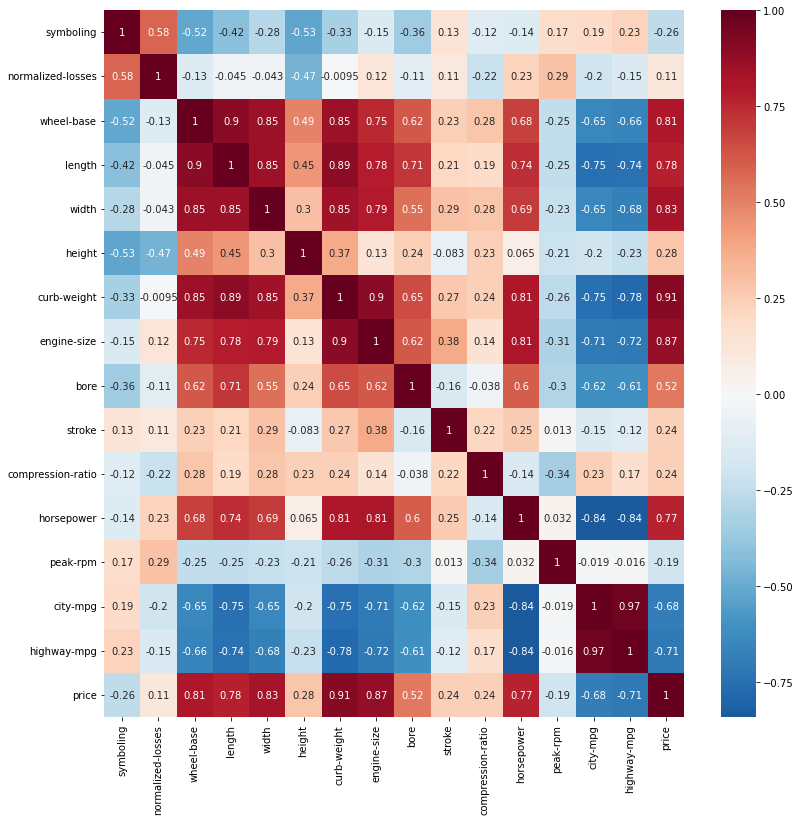

In [20]:
plt.figure(figsize=(13, 13))

sns.heatmap(df.corr(), annot=True, cmap="RdBu_r", center=0);

Beaucoup de variables sont hautement corrélées entre elles (corrélation > 80), d'autres sont très peu corrélées à la variable 'price'.  

Il est donc recommandé de simplifier notre modèle en choisissant uniquement les variables ayant une corrélation concrète avec la variable cible 'price'. Parmi les groupes de variables très corrélées entre elles, on ne retient que celle qui est la plus corrélée avec la variable 'price.

Pour valider l'hypothèse de linéarité, il faut également vérifier que les relations entre les différents attributs et la variable 'price' aient un aspect linéaire.  
Pour cela, on peut utiliser la fonction pairplot de seaborn qui affiche pour un DataFrame donné, une matrice de nuages de points entre chaque paire de variables qu'il contient.

- (n) Afficher une matrice des nuages de points entre les variables 'curb-weight', 'horsepower', 'highway-mpg', 'height', 'bore', 'width' et 'price' de df.

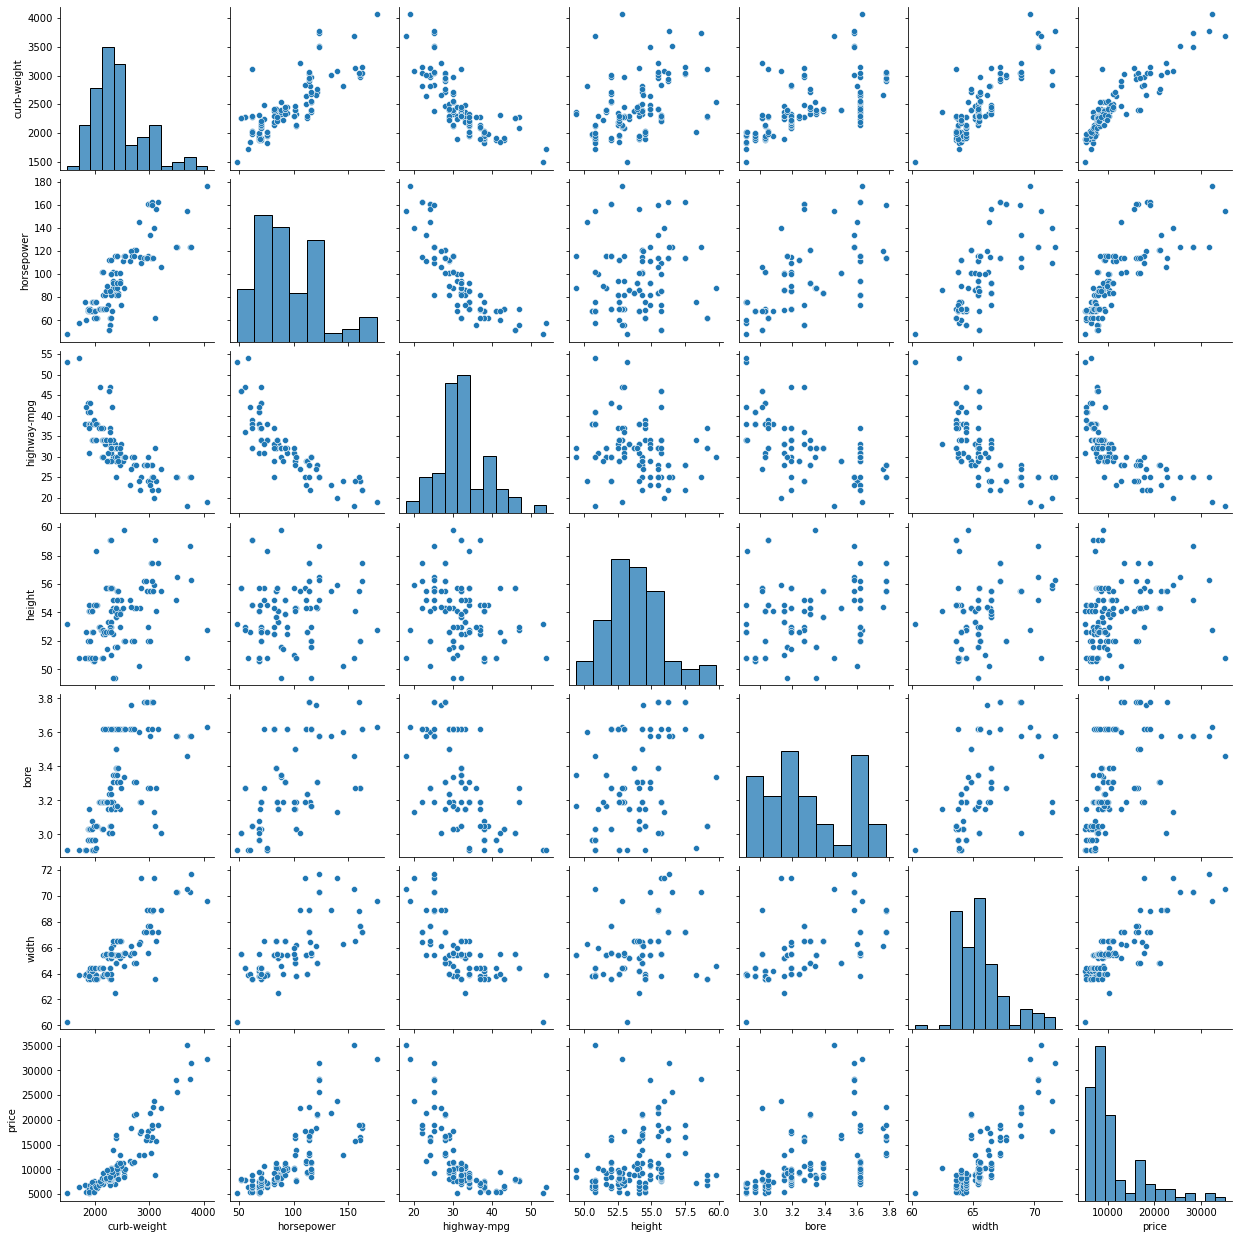

In [21]:
sns.pairplot(df[['curb-weight', 'horsepower', 'highway-mpg', 'height', 'bore', 'width', 'price']]);

On observe facilement les variables ayant une relation qui s'apparente à une relation linéaire avec la variable 'price'.  

Par exemple, l'attribut 'height' n'a plausiblement pas de relation linéaire avec 'price'.  

Les informations obtenues ici rejoignent les résultats de la matrice de corrélation affichée plus haut et nous permettent d'envisager une liste de variables significatives suffisantes pour le modèle de régression.

- (o) Créer une liste 'signif_features' qui contient les noms des variables 'curb-weight', 'horsepower', 'bore', 'width'.

In [23]:
signif_features = ['curb-weight', 'horsepower', 'bore', 'width']
signif_features

['curb-weight', 'horsepower', 'bore', 'width']

## Modèle affiné
- (a) Créer un modèle de régression lr2 et l'entraîner uniquement avec les variables signif_features de X_train.

In [24]:
lr2 = LinearRegression()
lr2.fit(X_train[signif_features], y_train)

LinearRegression()

- (b) Afficher le score (R²) du modèle sur l'échantillon d'entraînement utilisé.

In [25]:
lr2.score(X_train[signif_features], y_train)

0.8526992245715691

- (c) Afficher le score (R²) du modèle sur les variables signif_features de l'échantillon de test.

In [26]:
lr2.score(X_test[signif_features], y_test)

0.8333179602570863

La sélection des variables a permis de réduire l'over-fitting (sur-apprentissage), c'est-à-dire l'écart entre le score obtenu sur l'échantillon d'apprentissage et l'échantillon test.  
Le modèle est plus consistant et plus robuste.
En outre, il fournit de meilleurs résultats sur l'échantillon test, et ne nécessite que 4 attributs explicatifs contre 15 dans le modèle précédent.

D'autre méthodes peuvent être utilisées dans scikit-learn pour la sélection de variables à partir de la relation entres les variables ou leur importance dans le modèle.

La fonction SelectKBest de sklearn.feature_selection permet de sélectionner, à partir d'un jeu de données et d'une variable cible, les k variables les plus significatives par rapport à une fonction de score utilisée, par exemple la fonction f_regression.

La fonction f_regression de sklearn.feature_selection calcule pour chaque attribut la statistique associée au test de significativité de cet attribut par rapport à la variable cible, ainsi que la p-value associée.

- (d) Importer les deux fonctions mentionnées ci-dessus.
- (e) Créer un sélecteur sk grâce à la fonction SelectKBest, en utilisant les résultats de la fonction f_regression et un nombre de variable k = 3.
- (f) Ajuster le sélecteur sk aux tableaux data et target, grâce à la méthode fit.
- (g) Afficher les noms des colonnes de data sélectionnées par le sélecteur, grâce à la méthode get_support qui retourne le booléen True pour chaque colonne sélectionnée du jeu de données et False pour les autres.

In [27]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

sk = SelectKBest(f_regression, k=3)

sk.fit(X=data, y=target)

data.columns[sk.get_support()]

Index(['width', 'curb-weight', 'engine-size'], dtype='object')

On remarque que les 3 variables sélectionnées sont les variables les plus corrélées à la variable 'price'.

- (h) Utiliser la méthode transform du sélecteur sk pour créer les tableaux sk_train et sk_test à partir de X_train et X_test.

In [28]:
sk_train = sk.transform(X_train)
sk_test = sk.transform(X_test)

- (i) Créer un modèle de régression linéaire à partir de sk_train et y_train.
- (j) Afficher le score du modèle sur l'échantillon d'entraînement ainsi que sur sk_test.

In [29]:
sklr = LinearRegression()
sklr.fit(sk_train, y_train)

print(sklr.score(sk_train, y_train))
print(sklr.score(sk_test, y_test))

0.8500874726487171
0.8385674383782986


Le modèle obtient de bonnes performances, à la fois sur l'échantillon train et l'échantillon test. Et ceci, avec uniquement les 3 variables les plus significatives (même si elles sont corrélées).

La fonction SelectFromModel permet de sélectionner les variables importantes d'un DataFrame, à partir d'un modèle créé possédant un attribut coef_ ou feature_importances.
Le modèle peut être déjà 'ajusté' ou non.

- (k) Importer la classe SelectFromModel.
- (l) Instancier un modèle de régression linéaire lr.
- (m) Créer un sélecteur sfm instance de la classe SelectFromModel, à partir du modèle lr créé.
- (n) Créer les tableaux normalisés X_train_scaled et X_test_scaled, à partir de X_train et X_test.  

NB : La standardisation est obligatoire lorsque l'on utilise les coefficients d'un modèle de regression, si les variables ne sont pas du même ordre.

- (o) Sauvegarder les colonnes de X_train_scaled sélectionnées par sfm dans sfm_train et celles de X_test_scaled dans sfm_test, grâce à la méthode transform.

In [30]:
from sklearn.feature_selection import SelectFromModel

lr = LinearRegression()

sfm = SelectFromModel(lr)

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)

X_test_scaled = scaler.transform(X_test)

sfm_train = sfm.fit_transform(X_train_scaled, y_train)

sfm_test = sfm.transform(X_test_scaled)

- (p) Afficher les noms des colonnes sélectionnés par sfm grâce à la méthode get_support.

In [31]:
data.columns[sfm.get_support()]

Index(['wheel-base', 'length', 'width', 'curb-weight', 'engine-size'], dtype='object')

- (q) Créer un modèle à partir des variables sélectionnées et affichez le score du modèle sur les échantillons d'entraînement et de test.

In [32]:
sfmlr = LinearRegression()
sfmlr.fit(sfm_train, y_train)

print(sfmlr.score(sfm_train, y_train))
print(sfmlr.score(sfm_test, y_test))

0.8695959523165455
0.8491475782766559


# 4 - Régression linéaire régularisée : Ridge, Lasso 

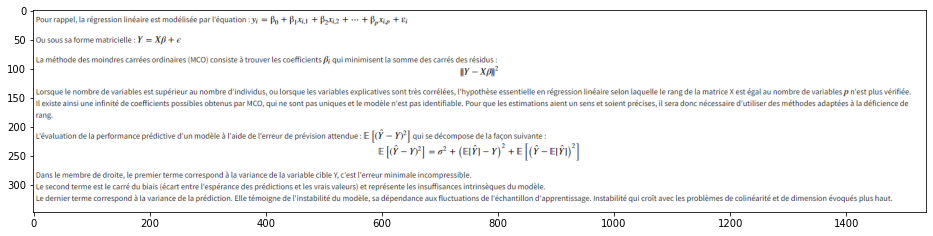

In [36]:
from matplotlib import image
img = image.imread('reglin_mat.png')
plt.figure(figsize=(16, 10))
plt.imshow(img)

## La Régression régularisée
L'objectif de la régularisation est d'éviter le sur-apprentissage c-à-d apprendre de l'échantillon de données d'apprentissage, mais pas trop (pas de sur-dépendance du modèle).
Pour se faire, le principe est d'accepter une légère augmentation du biais pour obtenir une réduction plus que proportionnelle de la variance.  

L'idée est de réguler un peu plus fermement la modélisation en imposant des contraintes sur les coefficients estimés de la régression (contraintes sur les valeurs que pourront prendre les  βi  dans leur ensemble).

On parle ainsi de " shrinkage " (rétrécissement) : on rétrécit les plages de valeurs que peuvent prendre les paramètres estimés.

À la différence de la régression classique, où les variables sont en général conservées telles que mesurées, il est d'usage de centrer et réduire les variables explicatives, pour éviter que les variables à forte variance aient trop d'influence.  
En général, la valeur de  βi  dépend de l'échelle de mesure de la variable explicative associée.  
Lors du calcul de la norme, afin de ne pas pénaliser ou favoriser un coefficient, il est souhaitable que chaque coefficient soit affecté de manière "semblable".  
Une manière de réaliser cet équilibre consiste à centrer et réduire toutes les variables.

La variable cible y doit être centrée pour évacuer la constante de la régression (qui ne doit pas être pénalisée), la cible y peut être éventuellement réduite aussi.

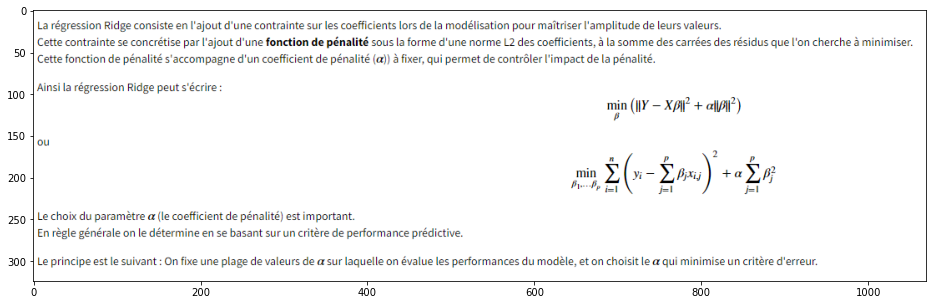

In [35]:
from matplotlib import image
img = image.imread('reglin_ridge.png')
plt.figure(figsize=(16, 16))
plt.imshow(img)

In [1]:
import numpy as np
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


- (b) Importer le fichier 'automobiles.csv' dans un DataFrame df.
- (c) Normaliser l'ensemble des données à l'aide de la classe preprocessing.StandardScaler.
- (d) Stocker la variable 'price' de df dans target et le reste des variables dans data.
- (e) Séparer les données en un ensemble d'apprentissage (X_train, y_train) et un ensemble de test (X_test, y_test) contenant 20% des données. Utiliser le paramètre random_state = 789 pour obtenir les mêmes résultats que la correction (optionnel).

In [2]:
df = pd.read_csv('automobiles.csv', sep=';')

df[df.columns] = pd.DataFrame(preprocessing.StandardScaler().fit_transform(df))

data = df.drop('price', axis=1)
target = df['price']

X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=789)

In [5]:
data.shape

(120, 15)

La classe Ridge du module sklearn.linear_model permet de créer un modèle de régression Ridge de la même manière qu'une régression linéaire classique, auquel on fournit un paramètre  αα , qui vaut 1 par défaut.

Pour obtenir le meilleur modèle prédictif possible, il est préférable d'utiliser la classe RidgeCV à qui l'on donne dans le paramètre alphas une liste de valeurs pour  αα  que la fonction parcourra pour créer et évaluer plusieurs modèles par validation croisée, puis sélectionner le  αα  entraînant les meilleures performances.

- (f) Importer la classe RidgeCV de sklearn.linear_model.
- (g) Créer un modèle de régression Ridge ridge_reg qui choisira le meilleur alpha parmi:(0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100), puis l'ajuster aux données d'apprentissage.

In [79]:
from sklearn.linear_model import RidgeCV

ridge_reg = RidgeCV(alphas= (0.001, 0.01, 0.1, 0.3, 0.7, 1, 10, 50, 100))
ridge_reg.fit(X_train, y_train) 

RidgeCV(alphas=array([1.e-03, 1.e-02, 1.e-01, 3.e-01, 7.e-01, 1.e+00, 1.e+01, 5.e+01,
       1.e+02]))

- (h) Afficher le  α  retenu par le modèle grâce à l'attribut alpha_.
- (i) Afficher le score (R²) du modèle sur l'ensemble d'entraînement puis sur l'ensemble de test.

In [80]:
print('alpha sélectionné par c-v :', ridge_reg.alpha_)
print('score train :', ridge_reg.score(X_train, y_train))
print('score test :', ridge_reg.score(X_test, y_test))

alpha sélectionné par c-v : 10.0
score train : 0.8875929034121672
score test : 0.8954911905885832


- (j) Stocker dans ridge_pred_train les valeurs ajustées du modèle.
- (k) Stocker dans ridge_pred_test les prédictions du modèle pour X_test.
- (l) Afficher l'erreur quadratique moyenne de prédiction pour ridge_pred_train et ridge_pred_test, grâce à la fonction mean_squared_error.

In [81]:
ridge_pred_train = ridge_reg.predict(X_train)
ridge_pred_test = ridge_reg.predict(X_test)

print('mse train :', mean_squared_error(ridge_pred_train, y_train))
print('mse test :', mean_squared_error(ridge_pred_test, y_test))

mse train : 0.12082371573658146
mse test : 0.06243089450167777


Malgré un score correct, l'écart d'erreur assez significatif entre l'échantillon d'entraînement et l'échantillon de test permet de conclure que le modèle overfit sur les données d'apprentissage.

## Regression Lasso

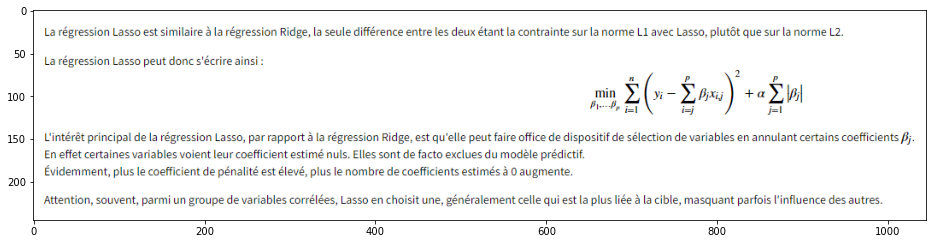

In [82]:
from matplotlib import image
img = image.imread('reglin_lasso.png')
plt.figure(figsize=(16, 16))
plt.imshow(img)

- (a) Importer la classe Lasso de sklearn.linear_model, qui implémente la régression Lasso.
- (b) Créer un modèle de régression Lasso, lasso_r, avec  α=1
(valeur par défaut sur scikit-learn), ajusté sur les données d'entraînement.

In [3]:
from sklearn.linear_model import Lasso

lasso_r = Lasso(alpha=1)

lasso_r.fit(X_train, y_train)

Lasso(alpha=1)

Les coefficients estimés sont récupérables, comme pour toute régression linéaire, dans l'attribut coef_.

- (c) Afficher les coefficients estimés par le modèle.

In [4]:
lasso_r.coef_ # 15 coef beta car 5 cols dans data features

array([-0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,
       -0., -0.])

Tous les coefficients sont nuls.
Manifestement, la valeur  α=1.0  ne convient pas à nos données.

- (d) Créer un nouveau modèle de régression Lasso, lasso_reg, avec  α=0.1  ajusté sur les données d'entraînement.

In [6]:
lasso_reg = Lasso(alpha=0.1)

lasso_reg.fit(X_train, y_train)

Lasso(alpha=0.1)

In [8]:
lasso_reg.coef_ # ok pas tous les 15 beta sont nuls

array([ 0.        ,  0.00422895,  0.        ,  0.        ,  0.15316415,
        0.        ,  0.53068915,  0.1665711 , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ])

- (e) Afficher un graphique représentant la valeur estimée du coefficient pour chaque variable de data.

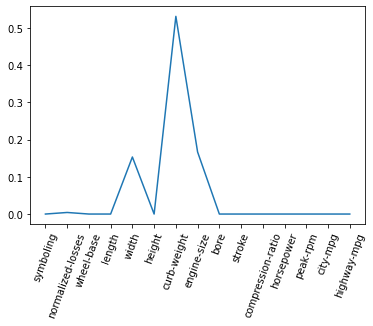

In [85]:
lasso_coef = lasso_reg.coef_

plt.plot(range(len(data.columns)), lasso_coef)
plt.xticks(range(len(data.columns)), data.columns.values, rotation=70);

In [109]:
lasso_coef

array([ 0.        ,  0.00422895,  0.        ,  0.        ,  0.15316415,
        0.        ,  0.53068915,  0.1665711 , -0.        , -0.        ,
        0.        ,  0.        ,  0.        , -0.        , -0.        ])

Seulement 5 variables sur 15 ont été sélectionnées par le modèle, avec le paramètre  α=0.1 .  
ICI ON NE VOIT QUE 4 VARIABLE (celles différentes de 0 ), la 5eme est dans le creu apres 1er gros pic

Les coefficients des 10 autres variables sont estimées à 0.

- (f) Afficher le score ( R2 ) du modèle sur l'ensemble d'apprentissage et l'ensemble de test.

In [86]:
print('score train :', lasso_reg.score(X_train, y_train))
print('score test :', lasso_reg.score(X_test, y_test))

score train : 0.8413142863274602
score test : 0.8125808678176384


- (g) Stocker dans lasso_pred_train les valeurs ajustées du modèle.
- (h) Stocker dans lasso_pred_test les prédictions du modèle pour X_test.
- (i) Afficher l'erreur quadratique moyenne de prédiction pour lasso_pred_train et lasso_pred_test, grâce à la fonction mean_squarred_error.

In [87]:
lasso_pred_train = lasso_reg.predict(X_train)
lasso_pred_test = lasso_reg.predict(X_test)

print('mse train :', mean_squared_error(lasso_pred_train, y_train))
print('mse test :', mean_squared_error(lasso_pred_test, y_test))

mse train : 0.17056750100511753
mse test : 0.11195940452073316


Les résultats sont meilleurs sur l'échantillon de test qu'avec la régression Ridge, et ce en utilisant uniquement 5 variables.
De plus, l'écart se resserre entre les erreurs / scores : le modèle fait moins d'overfitting.

Lorsque  α  est trop élevé, tous les coefficients de la régression sont nuls, comme vu ici.  
Lorsque  α  est trop faible, proche de 0, nous obtenons les coefficients de la régression linéaire multiple usuelle.   
Il est toujours intéressant de comparer les variables selectionnées ou non par la régression Lasso, en fonction du  α .

La fonction lasso_path permet de produire les coefficients éstimés corrrespondants aux différents  α  qu'elle reçoit en arguments.

Elle prend comme argument les données de l'échantillon d'apprentissage et la variable cible associée et retourne les  α  testés dans l'ordre décroissant, ainsi que la matrice des coefficients de taille  p×m  où p désigne le nombre de variables explicatives, et m le nombre de valeurs de  α  essayées.  
La fonction de scikit-learn permet de sélectionner automatiquement un jeu de valeurs  αα  à tester, mais il est possible également de les spécifier explicitement dans l'argument alphas.

- (j) Importer la fonction lasso_path de sklearn.linear_model.
- (k) Créer une liste mes_alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0).
- (l) Retourner dans alpha_path, et coefs_lasso (grâce à la syntaxe alpha_path, coefs_lasso, _ =) les  α  ainsi que la matrice des coefficients associés aux données (X_train,     y_train) et à la liste mes_alphas.
- (m) Vérifier les dimensions de coefs_lasso.

In [102]:
from sklearn.linear_model import lasso_path

mes_alphas = [0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0]

alpha_path, coefs_lasso, _ = lasso_path(X_train, y_train, alphas=mes_alphas)

coefs_lasso.shape

(15, 10)

(n) Afficher dans un graphique, pour chaque variable explicative, la courbe des valeurs du coefficient estimé correspondant en fonction des valeurs prises par  α  dans alpha_path

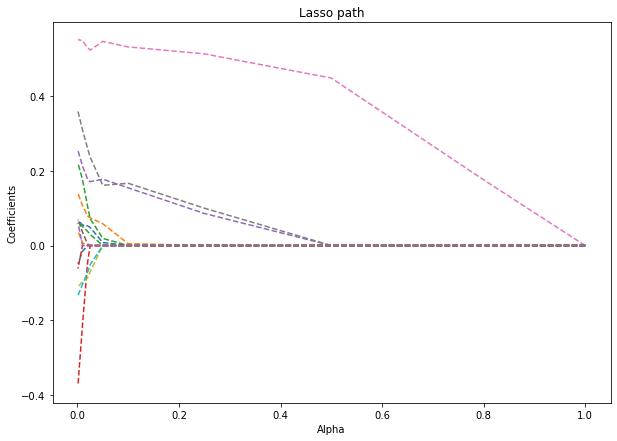

In [103]:
plt.figure(figsize=(10, 7))

for i in range(coefs_lasso.shape[0]):
    plt.plot(alpha_path, coefs_lasso[i,:], '--')

plt.xlabel('Alpha')
plt.ylabel('Coefficients')
plt.title('Lasso path');

Le graphique nous montre qu'à partir de  α=0.3 ( sur les vrai données !!!), plus que 3 variables seulement sont sélectionnées par le modèle, et qu'à  α=1 , effectivement, tous les coefficients sont nuls.

Nous disposons ainsi de scénarios de solutions pour différentes valeurs de  α . Mais nous ne savons pas laquelle est la plus performante en prédiction.
Il existe, tout comme pour la régression Ridge, une classe LassoCV qui permet de trouver le  α  optimal en fonction de la performance prédictive, par validation croisée.

La fonction retourne les  α  testés dans l'attribut alphas_, le  α  retenu dans l'attribut alpha_, mais également dans l'attribut model.mse_path_ la matrice contenant pour chaque  α  la valeaur du MSE pour chaque échantillon de cross-validation obtenu.

- (o) Créer un modèle model_lasso à partir de la fonction LassoCV, avec le paramètre cv=10, et l'entraîner sur l'ensemble d'apprentissage (X_train, y_train).
- (p) Récupérer dans alphas les différents  α  testés par le modèle.
- (q) Dans un graphique, afficher :
  - la courbe représentant les erreurs MSE en fonction des valeurs de  αα  pour chaque échantillon de la validation croisée.
  - la courbe représentant la moyenne des scores MSE sur tous les échantillons, en fonction des valeurs de  αα  testés.
  - une ligne verticale sur la valeur de  αα  sélectionnée par le modèle.

In [104]:
alphas.shape

(100,)

In [105]:
model_lasso.mse_path_.shape

(100, 10)

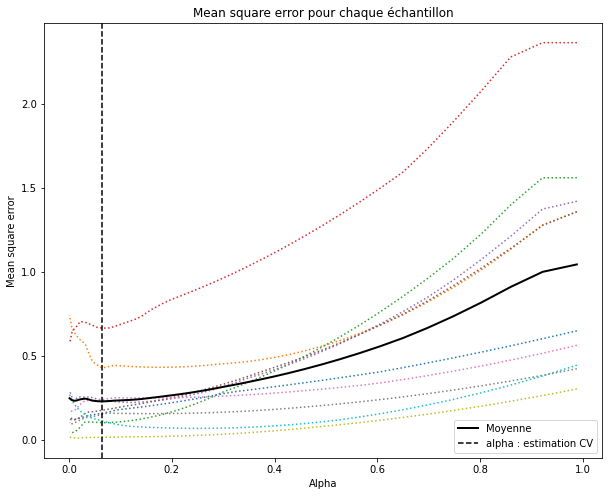

In [106]:
from sklearn.linear_model import LassoCV

model_lasso = LassoCV(cv=10).fit(X_train, y_train)

alphas = model_lasso.alphas_

plt.figure(figsize=(10, 8))

plt.plot(alphas, model_lasso.mse_path_, ':')
plt.plot(alphas, model_lasso.mse_path_.mean(axis=1), 'k', label='Moyenne', linewidth=2)

plt.axvline(model_lasso.alpha_, linestyle='--', color='k', label='alpha : estimation CV')

plt.xlabel('Alpha')
plt.ylabel('Mean square error')
plt.title('Mean square error pour chaque échantillon')
plt.legend();


- (r) Afficher le score  R2  et le MSE obtenu sur l'échantillon de test par le modèle model_lasso.

In [107]:
pred_test = model_lasso.predict(X_test)

print('score test :', model_lasso.score(X_test, y_test))
print('mse test :', mean_squared_error(pred_test, y_test))

score test : 0.8327644792887696
mse test : 0.09990223034074108


In [108]:
pred_test

array([-0.46781037, -0.88779987, -0.25317573, -0.60869921, -0.83103581,
       -0.30822147, -0.84409512,  0.15646759, -0.75378086, -0.94614338,
        0.65444473,  1.34460379, -0.61080908, -0.30253872,  0.05871728,
       -0.33102713, -0.86071249, -0.62613161,  1.25500547, -0.00868402,
       -0.52929476,  0.30059805, -0.51310532, -0.26710831])

NB : Il s'agit des meilleurs scores et taux d'erreur obtenus parmi les modèles de régression régularisée testés.

# 5 - Qui sera le MVP ? - Elastic Net
Les données analysées dans cet exercice proviennent d'un jeu de données concernant des joueurs de NBA et leurs performances pour la saison 2013-2014.

L'objectif est de réussir à prédire le nombre de points inscrits par joueur durant la saison, en fonction de différentes variables qui correspondent pour la plupart aux caractéristiques des matchs auquel le joueur a participé et ses performances sur le terrain.

Préparation des données
Le dataset contient 20 colonnes, parmi lesquelles :

- Champ	Description
- player	Prénom et Nom du joueur
- age	L'âge du joueur au début de la saison
- g	Nombre de matchs joués
- gs	Nombre de matchs débutés
- mp	Nombre de minutes joués par saison
- fg.	Pourcentage de field goals (paniers tirés autres que lancers francs) réussis
- tov	Nombre de récupération de ballon
Toutes les abréviations utilisées concernant le basket-ball sont définies ici.

- (a) Exécuter la cellule suivant pour importer les modules nécessaires.


In [54]:
import numpy as np
import pandas as pd

from sklearn import model_selection, preprocessing

from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate, train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

(b) Importer le fichier 'nba_2013.csv' dans un DataFrame appelé nba.

In [56]:
nba = pd.read_csv('nba_2013.csv', sep=';')

- (d) Modifier les indices du DataFrame pour qu'ils contiennent le nom des joueurs et l'abréviation de l'équipe à laquelle ils appartiennent.  
Exemple : Pour Kevin Durant, l'indice sera : Kevin Durant - OKC.

In [57]:
nba.index = nba['player'] + ' - ' + nba['bref_team_id']

- (e) Supprimer les lignes contenant des valeurs manquantes.
- (f) Afficher les différentes modalités prises par la variables pos.
- (g) Supprimer les lignes contenant des valeurs aberrantes pour la variable pos.

In [58]:
nba = nba.dropna()

print(pd.crosstab(nba.pos, 'count'))  # 'count' est le nom donné à la colonne dans la crosstab, car 1 seul col donnée => un count réalisé en fait

nba = nba[nba['pos']!='G']

col_0  count
pos         
C          5
PF         9
PG        14
SF        15
SG        15


- (h) Sauvegarder la variable pos de nba dans un vecteur pl_pos.
- (i) Supprimer les colonnes 'season', 'player', 'bref_team_id', 'pos' du DataFrame nba.
- (j) Créer un objet StandardScaler appelé scaler, et normaliser les colonnes de nba, en gardant les mêmes indices.

In [59]:
pl_pos = nba['pos']

nba.drop(['season', 'player', 'bref_team_id', 'pos'], axis=1, inplace=True)

scaler = preprocessing.StandardScaler().fit(nba)

nba[nba.columns] = pd.DataFrame(scaler.transform(nba), index=nba.index)

- (k) Joindre à nba les variables indicatrices obtenues grâce aux modalités du vecteur pl_pos.

In [60]:
nba = nba.join(pd.get_dummies(pl_pos, prefix='pos'))

- (l) Créer le DataFrame data à partir de nba en supprimant les colonnes 'pts' et 'pos_SG'.
- (m) Créer le vecteur target à partir de le colonne 'pts'.

In [61]:
data = nba.drop(['pts','pos_SG'], axis=1)
target = nba['pts']

- (n) Séparer data et target en échantillons d'apprentissage et de test (80% - 20%).
- (o) Ajouter random_state=101 à la fonction train_test_split pour une reproductibilité des résultats.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=101)

- (p) Afficher une heatmap des corrélations entre chaque colonne de nba.

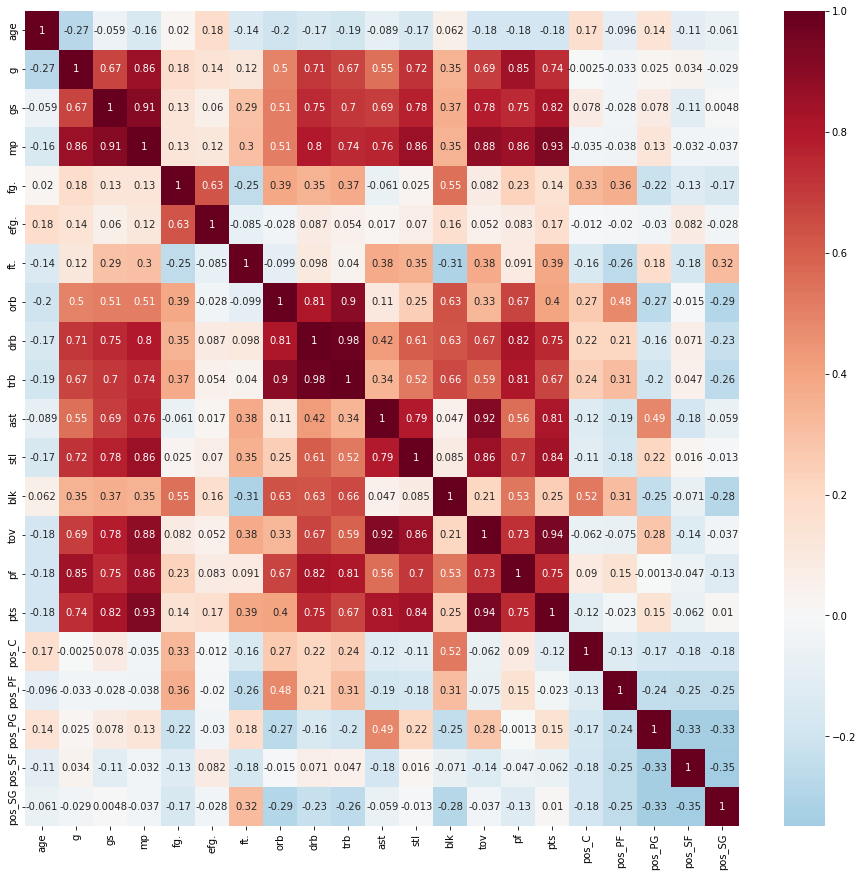

In [63]:
plt.figure(figsize=(16, 15))

sns.heatmap(nba.corr(), annot=True, cmap='RdBu_r', center=0);

La variable mp comptant le nombre de minutes jouées sur la saison est visiblement la plus corrélée à la variable cible.

## Définition du modèle
- (a) Créer un modèle de régression linéaire simple appelé model_1 pour expliquer le nombre de points marqués par un joueur en fonction du nombre de minutes jouées, à partir de l'ensemble d'entraînement.

In [64]:
model_1 = LinearRegression()
model_1.fit(X_train[['mp']], y_train)

LinearRegression()

- (b) Afficher le score R² et le RMSE du modèle sur l'échantillon d'entraînement puis sur celui de test.

In [65]:
print('score train :', model_1.score(X_train[['mp']], y_train))
print('score test :', model_1.score(X_test[['mp']], y_test))

pred = model_1.predict(X_train[['mp']])
pred_test = model_1.predict(X_test[['mp']])

print('rmse train :', np.sqrt(mean_squared_error(y_train, pred)))
print('rmse test :', np.sqrt(mean_squared_error(y_test, pred_test)))


score train : 0.8744266703835752
score test : 0.8126195989143988
rmse train : 0.33356811896128097
rmse test : 0.501791721992346


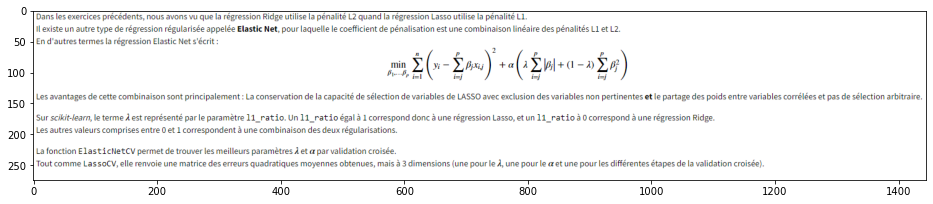

In [68]:
from matplotlib import image
img = image.imread('reglin_electicnet.png')
plt.figure(figsize=(16, 16))
plt.imshow(img)

- (c) Importer la fonction ElasticNetCV de sklearn.linear_model.
- (d) Créer un modèle de régression Elastic Net, model_en qui parcourra les paramètres l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99) et alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0)au cours d'une validation croisée à 8 échantillons.
- (e) Entraîner le modèle sur X_train et y_train.

In [69]:
from sklearn.linear_model import ElasticNetCV

model_en = ElasticNetCV(cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99), 
                        alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0))

model_en.fit(X_train, y_train)
#model= LassoCV(cv=10).fit(X_train, y_train)

ElasticNetCV(alphas=(0.001, 0.01, 0.02, 0.025, 0.05, 0.1, 0.25, 0.5, 0.8, 1.0),
             cv=8, l1_ratio=(0.1, 0.25, 0.5, 0.7, 0.75, 0.8, 0.85, 0.9, 0.99))

- (f) Afficher l'intercept et les coefficients estimés pour chaque variable de data.

In [70]:
coeffs = list(model_en.coef_)
coeffs.insert(0, model_en.intercept_)
feats = list(data.columns)
feats.insert(0, 'intercept')

pd.DataFrame({'valeur estimée': coeffs}, index=feats)

,valeur estimée
intercept,0.014801
age,-0.013534
g,-0.000000
gs,-0.000000
mp,0.419832
fg.,-0.023433
efg.,0.085988
ft.,0.049705
orb,-0.075302
drb,0.095283


- (g) Afficher dans un graphique, pour chaque valeur de l1_ratio, la courbe représentant la moyenne des erreurs MSE obtenues par validation croisée en fonction des valeurs de  α .

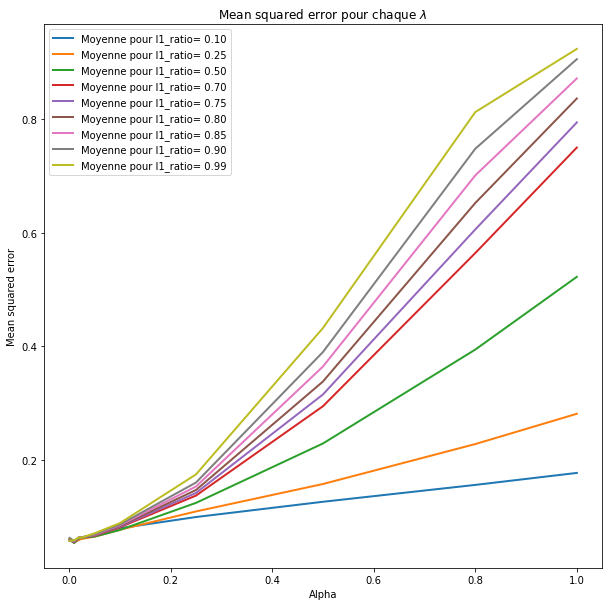

In [71]:
alphas = model_en.alphas_

plt.figure(figsize=(10, 10))

for i in range(model_en.mse_path_.shape[0]) :
    plt.plot(alphas, model_en.mse_path_[i,:,:].mean(axis=1),
             label='Moyenne pour l1_ratio= %.2f' %model_en.l1_ratio[i], linewidth=2)

plt.xlabel('Alpha')
plt.ylabel('Mean squared error')
plt.title('Mean squared error pour chaque $\lambda$')
plt.legend();

- (h) Stocker les prédictions du modèle pour X_train et X_test dans les tableaux respectifs pred_train et pred_test.
- (i) Afficher les racines des erreurs quadratiques moyennes pour les deux échantillons.

In [72]:
pred_train = model_en.predict(X_train)
pred_test = model_en.predict(X_test)
print(np.sqrt(mean_squared_error(y_train, pred_train)))
print(np.sqrt(mean_squared_error(y_test, pred_test)))

0.16208030143490543
0.29283080566492803


- (j) Afficher les scores R² pour les deux échantillons.

In [73]:
print('score train :', model_en.score(X_train, y_train))
print('score test :', model_en.score(X_test, y_test))

score train : 0.9703524500474795
score test : 0.9361867734863575


- (k) Créer les variables moy et ec contenant respectivement la moyenne et l'écart type calculés par l'objet scaler et utilisés pour transformer les données.

In [75]:
moy = scaler.mean_[-1]
ec = scaler.scale_[-1]
print('moyenne :', moy)
print('ecart-type :', ec)

moyenne : 613.0862068965517
ecart-type : 516.8756364957181


- (l) Afficher côte à côte les points véritablement observés pour chaque joueur, et les points prédits par le modèle Elastic Net.

In [76]:
pd.DataFrame({'points_observés': (y_test*ec)+moy, 'points_predits' : np.round((pred_test*ec)+moy)}, 
             index=X_test.index).head(7)

,points_observés,points_predits
Evan Fournier - DEN,638.0,765.0
Kent Bazemore - TOT,403.0,472.0
Jordan Hamilton - TOT,404.0,402.0
DeJuan Blair - DAL,497.0,488.0
Kirk Hinrich - CHI,666.0,836.0
Arnett Moultrie - PHI,36.0,-27.0
Francisco Garcia - HOU,315.0,272.0
